# Intersection Crash Analysis Using Only Intersection Characteristics

Linear regression analysis of factors affecting red light crashes

This data is created by me. It is from dictionary contained in this repository under the file 'int_chars.py'.

To create this file, I went through all 180+ intersections with red light cameras. I cross referenced it with a map at https://data.cityofchicago.org/Transportation/Average-Daily-Traffic-Counts-Map/pf56-35rv and google maps to compile the following data.

- roads (list): of road segments as identified in average-daily-traffic-counts db in link above. Used to determine volume of traffic.
- protected_turn (int): How any of the left turns are protected (left turn arrow).
- total_lanes (int): Count of total lanes. If a road has one lane for all directions N/E/S/W bound traffic, that counts as 4. Rangees from 3 to 14 lanes.
- medians (int): Count of physical median barriers that extend up to intersection.
- exit (int): 0 if no exit. 1 if exit on/off ramp within 100m of center of intersection. Traffic flow is affected by proximity to exit.
- split (int): 1 if it is a divided boulevard (common in Chicago) where divided lanes are split by traffic signals in median. Look at examples on google map.
- way (int): directions of traffic flow. A 4 way intersection might be NESW.
- underpass (int): number of ways that have an underpass extending up to the intersection. These are notoriously bad intersections in Chicago.
- no_left (int): number of no left turn signs. Usually with smaller streets onto larger roads or high volumne intersections.
- angled (int): 1 if angle between two 2way roads is greater than 30 degrees (used 1/2/sqrt(3) rule to measure.
- triangle (int): 1 if three 2way roads meet intersect or form a triangle where all 3 roads <50m
- one_way (int): number of 1 way directions.
- turn_lanes (int): how many directions have physical and identified turn lanes for left hand turns.
- lat (float): latitude of center of inersection.
- long (float): longitude
- rlc (int): 1 for red light camera is present
- intersection (str): name of intersection as defined in signal_crashes table in db
- daily_traffic (int): volume of daily traffic through intersection. Sum of incoming roads from roads list.

The primary purpose of the data was to get lat/long for center of intersection to assign crash data more accurately than cam location which is often 20m or more away from center.   
The secondary purpose is to see what characteristics lead to more crashes.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from modules.myfuncs import *
import numpy as np
import sqlite3
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import metrics

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

pd.options.display.max_rows = 100

In [2]:
conn = create_connection('database/rlc.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc.db


In [3]:
print(sql_fetch_tables(c, conn))
#table_info(c, conn)  # use if you need to see columns

[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('all_hours',), ('int_startend',), ('intersection_chars',), ('signal_crashes',), ('daily_covid',), ('holidays',), ('rlc_all_hours',)]


## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

WHAT I REALLY NEED HERE
A single dataset with the following:
- daily intersection chars (all the stuff I entered)
- daily intersection crashes (injuries, deaths, number etc)
- daily wx (temp, precip mainly)
- daily congestion (might not need this)
- daily violations (already in the format)

In [4]:
table_info(c, conn)

cam_locations
	-camera_id
	-intersection
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

cam_startend
	-camera_id
	-start
	-end

daily_violations
	-intersection
	-camera_id
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

all_crashes
	-crash_record_id
	-rd_no
	-crash_date
	-posted_speed_limit
	-traffic_control_device
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-beat_of_occurrence
	-num_units
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-crash_hour
	-crash_day_of_week
	-crash_month
	-latitude
	-longitude
	-lane_cnt
	-interse

In [5]:
# v AS(SELECT dv.intersection,
#                 SUM(dv.violations) as violations,
#                 (CASE
#                       WHEN JulianDay(se.start) <= JulianDay('2017-09-01 00:00:00')
#                       AND JulianDay(se.end) > JulianDay('2020-12-31 00:00:00')
#                           THEN CAST(JulianDay('2020-12-31 00:00:00') - JulianDay('2017-09-01 00:00:00') as Integer)
                      
#                       WHEN JulianDay(se.start) > JulianDay('2017-09-01 00:00:00')
#                       AND JulianDay(se.end) > JulianDay('2020-12-31 00:00:00')
#                           THEN CAST (JulianDay('2020-12-31 00:00:00') - JulianDay(se.start) as Integer)
                      
#                       WHEN JulianDay(se.start) > JulianDay('2017-09-01 00:00:00')
#                       AND JulianDay(se.end) <= JulianDay('2020-12-31 00:00:00')
#                           THEN CAST ((se.end) - JulianDay(se.start) as Integer)
                    
#                       ELSE CAST (JulianDay(se.end) - JulianDay('2017-09-01 00:00:00') as Integer)
#                 END) AS days_active,
#                 COUNT(DISTINCT dv.camera_id) as n_cams,
#                 start,
#                 end,
#                 dv.day,
#                 dv.month,
#                 dv.year,
#                 dv.intersection

#         FROM daily_violations as dv
#         LEFT JOIN int_startend as se
#             ON dv.intersection = se.intersection

#         GROUP BY dv.year, dv.month, dv.day, dv.intersection
#         ), 


In [6]:
#create my db
crash_df = pd.read_sql_query('''
WITH v AS(SELECT violations,
                 intersection,
                 year,
                 month,
                 day
        FROM daily_violations
        WHERE violation_date >= \'2017-09-01\' AND violation_date <= \'2020-12-31\'
        GROUP BY year, month, day, intersection
        ),
    ic AS(SELECT *
         FROM intersection_chars
        ),
    cr AS(SELECT COUNT(crash_record_id) as n_crash,
                 SUM(injuries_total) as injuries,
                 intersection,
                 year,
                 month,
                 day,
                SUM(first_crash_type = 'REAR END') as rear_end
         FROM signal_crashes 
        WHERE crash_date >= \'2017-09-01\' AND crash_date <= \'2020-12-31\'
         GROUP BY year, month, day, intersection
        ),
    
    ah AS(SELECT intersection, 
                COUNT(year) as n_cams,
                year,
                month,
                day
            FROM rlc_all_hours 
            WHERE rlc_state=1 
            GROUP BY year, month, day, intersection
            ),
    
    rg AS(SELECT region_id, intersection 
        FROM intersection_cams
        GROUP BY intersection)
    

SELECT 
    (CAST(SUM(cr.injuries) AS FLOAT) / 3.25) as injuries_per_year,
    (CAST(SUM(cr.n_crash) AS FLOAT)/ 3.25) as crash_per_year,
    (CAST(SUM(cr.rear_end) AS FLOAT)/ 3.25) as rear_end_per_year,
    SUM(cr.n_crash) as n_crash,
    SUM(cr.injuries) as injuries,
    
    (CAST((ic.daily_traffic/ic.total_lanes) AS FLOAT)) as traffic_per_lane,
    ic.protected_turn/ic.way as protected_ratio,
    
    ic.daily_traffic,
    (ic.daily_traffic * 365) /1e6 AS million_cars_per_year,
    
    AVG(v.violations) as avg_violations,
    
    (ic.exit + ic.triangle + ic.angled + ic.underpass + way/4 - 1) as complexity,

    ic.*,

    (CAST(ic.total_lanes AS FLOAT)/ic.way) AS lanes_per_direction,  
    
    rg.region_id

FROM ah
LEFT JOIN v
    ON v.year = ah.year
    AND v.month = ah.month
    AND v.day = ah.day
    AND v.intersection = ah.intersection
LEFT JOIN cr
    ON cr.year = ah.year
    AND cr.month = ah.month
    AND cr.day = ah.day
    AND cr.intersection = ah.intersection
LEFT JOIN ic
    ON ic.intersection = ah.intersection
LEFT JOIN rg
    ON rg.intersection = ah.intersection
    
GROUP BY ah.intersection
ORDER BY ah.intersection
                                    ''', conn)

crash_df.head()

,injuries_per_year,crash_per_year,rear_end_per_year,n_crash,injuries,traffic_per_lane,protected_ratio,daily_traffic,million_cars_per_year,avg_violations,...,one_way,turn_lanes,lat,long,rlc,intersection,daily_traffic,speed,lanes_per_direction,region_id
0,10.461538,13.846154,3.384615,45.0,34.0,7183.0,0,43100,15.7315,6.180218,...,0,2,41.692362,-87.642423,1,111TH AND HALSTED,43100,35,1.5,26
1,0.000000,0.307692,0.000000,1.0,0.0,7083.0,1,42500,15.5125,6.321429,...,0,4,41.685089,-87.642094,1,115TH AND HALSTED,42500,35,1.5,26
2,6.769231,12.000000,1.846154,39.0,22.0,6966.0,1,41800,15.2570,6.405021,...,0,4,41.677774,-87.641930,1,119TH AND HALSTED,41800,35,1.5,26
3,5.846154,13.538462,2.461538,44.0,19.0,3650.0,0,36500,13.3225,8.567300,...,0,0,41.838441,-87.617338,1,31ST ST AND MARTIN LUTHER KING DRIVE,36500,35,2.5,16
4,5.846154,22.461538,4.923077,73.0,19.0,5300.0,0,42400,15.4760,3.211443,...,0,2,41.830281,-87.684775,1,35TH AND WESTERN,42400,35,2.0,15


In [7]:
crash_df.describe()
crash_df.isna().sum()
crash_df.dropna(inplace=True)

In [8]:
crash_df.drop_duplicates(inplace=True)
crash_df = crash_df.loc[:,~crash_df.columns.duplicated()]  # had a single dupe column preventing modeling
crash_df.describe()

,injuries_per_year,crash_per_year,rear_end_per_year,n_crash,injuries,traffic_per_lane,protected_ratio,daily_traffic,million_cars_per_year,avg_violations,...,no_left,angled,triangle,one_way,turn_lanes,lat,long,rlc,speed,lanes_per_direction
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,...,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.0,150.000000,150.000000
mean,4.664615,12.038974,3.128205,39.126667,15.160000,8077.553333,0.346667,51010.666667,18.618893,5.457007,...,0.246667,0.146667,0.166667,0.206667,3.280000,41.882333,-87.698173,1.0,35.700000,1.600333
std,3.689395,7.603059,2.123817,24.709941,11.990533,2210.363882,0.477503,14445.993600,5.272788,4.428081,...,0.633904,0.373388,0.373927,0.571078,1.295941,0.083481,0.050689,0.0,3.572358,0.427832
min,0.000000,0.307692,0.000000,1.000000,0.000000,3011.000000,0.000000,21600.000000,7.884000,1.575975,...,0.000000,0.000000,0.000000,0.000000,0.000000,41.677774,-87.812226,1.0,30.000000,1.000000
25%,2.461538,7.461538,1.846154,24.250000,8.000000,6585.500000,0.000000,41875.000000,15.284375,2.948526,...,0.000000,0.000000,0.000000,0.000000,2.000000,41.810519,-87.735973,1.0,35.000000,1.500000
50%,3.692308,10.461538,2.769231,34.000000,12.000000,8062.500000,0.000000,49200.000000,17.958000,3.908946,...,0.000000,0.000000,0.000000,0.000000,4.000000,41.903494,-87.698817,1.0,35.000000,1.500000
75%,5.846154,15.384615,3.923077,50.000000,19.000000,9650.000000,1.000000,58150.000000,21.224750,6.286126,...,0.000000,0.000000,0.000000,0.000000,4.000000,41.945854,-87.662371,1.0,35.000000,2.000000
max,30.461538,69.538462,16.615385,226.000000,99.000000,13925.000000,1.000000,105500.000000,38.507500,27.870066,...,3.000000,2.000000,1.000000,3.000000,6.000000,42.012234,-87.575373,1.0,65.000000,3.000000


In [9]:
crash_df.columns

Index(['injuries_per_year', 'crash_per_year', 'rear_end_per_year', 'n_crash',
       'injuries', 'traffic_per_lane', 'protected_ratio', 'daily_traffic',
       'million_cars_per_year', 'avg_violations', 'complexity',
       'protected_turn', 'total_lanes', 'medians', 'exit', 'split', 'way',
       'underpass', 'no_left', 'angled', 'triangle', 'one_way', 'turn_lanes',
       'lat', 'long', 'rlc', 'intersection', 'speed', 'lanes_per_direction',
       'region_id'],
      dtype='object')

In [10]:
# need to drop all of the rows I don't have data for
try:
    crash_df.dropna(subset=['crash_record_id'], inplace=True)
except Exception as e:
    print(e)

['crash_record_id']


In [11]:
# now drop out the rows that do not have daily violations. Should cure all our nans
# Some of these cams were only running before our query.
crash_df.dropna(subset=['avg_violations'], inplace=True)
crash_df.dropna(subset=['intersection'], inplace=True)
crash_df = crash_df.loc[:,~crash_df.columns.duplicated()]  # had a dupe column preventing modeling


Now we have a pretty solid dataframe to do analysis on the red light intersections.

We would like to know what factors affect the target (danger)

In [12]:
df_final = crash_df.copy()  # so I don't change my dataset
print(df_final.columns)
df_final.head()


Index(['injuries_per_year', 'crash_per_year', 'rear_end_per_year', 'n_crash',
       'injuries', 'traffic_per_lane', 'protected_ratio', 'daily_traffic',
       'million_cars_per_year', 'avg_violations', 'complexity',
       'protected_turn', 'total_lanes', 'medians', 'exit', 'split', 'way',
       'underpass', 'no_left', 'angled', 'triangle', 'one_way', 'turn_lanes',
       'lat', 'long', 'rlc', 'intersection', 'speed', 'lanes_per_direction',
       'region_id'],
      dtype='object')


,injuries_per_year,crash_per_year,rear_end_per_year,n_crash,injuries,traffic_per_lane,protected_ratio,daily_traffic,million_cars_per_year,avg_violations,...,triangle,one_way,turn_lanes,lat,long,rlc,intersection,speed,lanes_per_direction,region_id
0,10.461538,13.846154,3.384615,45.0,34.0,7183.0,0,43100,15.7315,6.180218,...,0,0,2,41.692362,-87.642423,1,111TH AND HALSTED,35,1.5,26
1,0.000000,0.307692,0.000000,1.0,0.0,7083.0,1,42500,15.5125,6.321429,...,0,0,4,41.685089,-87.642094,1,115TH AND HALSTED,35,1.5,26
2,6.769231,12.000000,1.846154,39.0,22.0,6966.0,1,41800,15.2570,6.405021,...,0,0,4,41.677774,-87.641930,1,119TH AND HALSTED,35,1.5,26
3,5.846154,13.538462,2.461538,44.0,19.0,3650.0,0,36500,13.3225,8.567300,...,0,0,0,41.838441,-87.617338,1,31ST ST AND MARTIN LUTHER KING DRIVE,35,2.5,16
4,5.846154,22.461538,4.923077,73.0,19.0,5300.0,0,42400,15.4760,3.211443,...,0,0,2,41.830281,-87.684775,1,35TH AND WESTERN,35,2.0,15


## Single variable regression

In [13]:
# Lets look at some regressions for all of my chosen columns

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

# I don't need to see regression analysis for all of my variables
target = 'crash_per_year'


continuous = [target, 'avg_violations', 'total_lanes', 'medians', 'way', 'speed', 'million_cars_per_year']


categoricals = ['exit', 'split', 'underpass', 'angled', 'triangle', 'no_left', 'region_id']



df_cont = df_final[continuous]



results = []

for idx, column in enumerate(df_cont.columns):
    print()
    print((column.upper() + " **** ") * 5)
    print ("Red Light Camera Crash - Injuries")
    
    f = '{}~{}'.format(target, column)  # create my model formula
    model = smf.ols(formula=f, data=df_cont).fit()  # fit the model
    print(model.summary())
    
#     fig, axes = plt.subplots(figsize=(12,10))
#     fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
#     fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
#     fig.tight_layout()
#     plt.show()
        
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

result_df = pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])
result_df.sort_values(by='r_squared')


CRASH_PER_YEAR **** CRASH_PER_YEAR **** CRASH_PER_YEAR **** CRASH_PER_YEAR **** CRASH_PER_YEAR **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.110e+32
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:01:10   Log-Likelihood:                 4770.5
No. Observations:                 150   AIC:                            -9537.
Df Residuals:                     148   BIC:                            -9531.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025    

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
1,avg_violations,0.075541,9.463724e+00,0.471916,6.645041e-04,4831.082017
6,million_cars_per_year,0.100645,3.521731e+00,0.457452,7.633114e-05,1299.535500
3,medians,0.103579,1.065608e+01,3.096031,5.916961e-05,2263.249572
5,speed,0.112764,-1.347549e+01,0.714691,2.657669e-05,1928.815942
4,way,0.123812,-8.281115e+00,4.932061,1.007750e-05,287.258885
2,total_lanes,0.323344,-3.087859e+00,2.303579,3.181382e-14,311.568432
0,crash_per_year,1.000000,3.996803e-15,1.000000,0.000000e+00,4474.867162


In [14]:
crash_df.columns

Index(['injuries_per_year', 'crash_per_year', 'rear_end_per_year', 'n_crash',
       'injuries', 'traffic_per_lane', 'protected_ratio', 'daily_traffic',
       'million_cars_per_year', 'avg_violations', 'complexity',
       'protected_turn', 'total_lanes', 'medians', 'exit', 'split', 'way',
       'underpass', 'no_left', 'angled', 'triangle', 'one_way', 'turn_lanes',
       'lat', 'long', 'rlc', 'intersection', 'speed', 'lanes_per_direction',
       'region_id'],
      dtype='object')

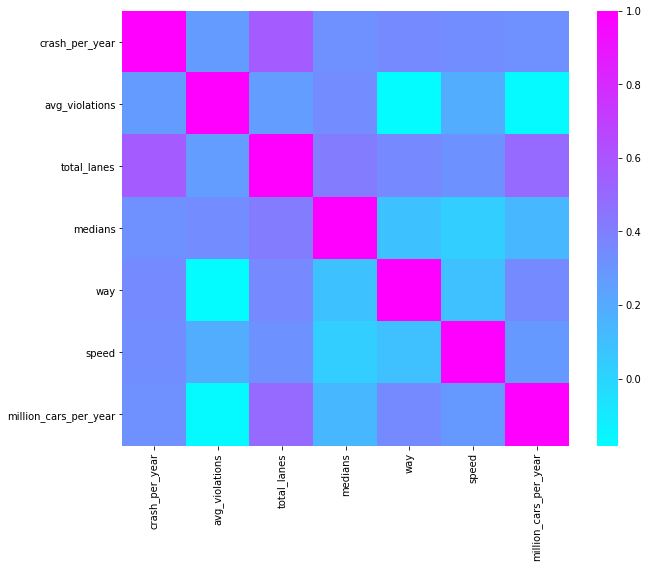

In [15]:
import seaborn as sns

# create correlation matrix
plt.figure(figsize = (10,8))
sns.heatmap(df_cont.corr(), center=0.4, cmap = "cool");

# One Hot Encoding

In [16]:
# get rid of categories that have high correlation and others.

df_continuous = df_cont.copy()
#df_ohe = crash_df[categoricals] # defined earlier
df_ohe = df_final[categoricals] # defined earlier
df_ohe[categoricals] = df_ohe[categoricals].astype(str)

# One hot encoding   
#df_ohe = pd.get_dummies(df_ohe, columns=['way'], drop_first=True)
df_final2 = pd.concat([df_continuous, df_ohe], axis=1)

In [17]:
df_final2 = df_final2.dropna()  # one intersection without crash_per_year (mislabeled)
df_final2.isna().sum()

crash_per_year           0
avg_violations           0
total_lanes              0
medians                  0
way                      0
speed                    0
million_cars_per_year    0
exit                     0
split                    0
underpass                0
angled                   0
triangle                 0
no_left                  0
region_id                0
dtype: int64

## Feature selection

In [18]:

X_ = df_final2.drop(target, axis=1)  # drop my potential targets

y = df_final2[target]

In [19]:
### FEATURE SELECTION

#from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge

linreg = LinearRegression()
selector = RFE(linreg, step=1, n_features_to_select=15)
selector = selector.fit(X_, y)
X_transformed = selector.transform(X_)

rfe_df = pd.DataFrame(list(zip(X_.columns, selector.support_, selector.ranking_, selector.estimator_.coef_)),
                  columns=['feature', 'support', 'rank', 'coef', ])


keepers = rfe_df.sort_values(by=['support', 'rank'], ascending=False)
keepers.head(10)

keepers.head(20)

manual_keep = ['total_lanes', 'way', 'speed', 'exit', 'split', 
               'underpass', 'triangle', 'million_cars_per_year']

## Apply my feature selection to data

In [20]:
#X_ = X.iloc[:,selector.support_] 
# Chose not to keep n_cams because I consider it a mitigation put in place, not inherent to intersection
X = X_[manual_keep]

# Linear Regression

In [21]:
# Import statsmodels.api as sm
from statsmodels.formula.api import ols

In [22]:
pred_sum = '+'.join(X.columns)
formula = target + '~' + pred_sum

In [23]:
model = ols(formula=formula, data=pd.concat([X, y], axis=1)).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         crash_per_year   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     15.54
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           2.25e-17
Time:                        16:01:31   Log-Likelihood:                -464.68
No. Observations:                 150   AIC:                             949.4
Df Residuals:                     140   BIC:                             979.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -14.5614      6.013     -2.422      0.017     -26.450      -2.673
exit[T.1]                 5.0483      1.500      3.366      0.001       2.083       8.014
split[T.1]               10.9146      2.502      4.362      0.000       5.968      15.861
underpass[T.1]            3.0185      2.235      1.350      0.179      -1.401       7.438
underpass[T.2]            0.8426      2.427      0.347      0.729      -3.957       5.642
triangle[T.1]             1.2937      1.405      0.921      0.359      -1.483       4.071
total_lanes               0.9155      0.345      2.655      0.009       0.234       1.597
way                       1.4879      1.036      1.436      0.153      -0.561       3.537
speed                     0.3128      0.137      2.286      0.024       0.042       0.583
million_cars_per_year     0.0949      0.108      0.881      0.380      -0.118       0.308
==============================================================================
Omnibus:                       10.494   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               13.840
Skew:                           0.426   Prob(JB):                     0.000988
Kurtosis:                       4.220   Cond. No.                         557.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The bad:
Large JB is troubling.  Errors are not normally distributed.
This is the lowest I could get the BIC and AIC.


The good
F-statistic looks okay with low pval.
Low skew value is good to see.

### Evaluate Model

In [24]:
def cross_val(model, X, y):
    # return a cross val score for my models
    pred = cross_val_score(model, X, y, cv=5, scoring='r2')
    return -pred.mean()

def print_evaluate(true, predicted):  
    # print out all of my stats for the model
    mae, mse, rmse, r2 = evaluate(true, predicted)
    print('MAE: {:.2f}'.format(mae))
    print('MSE: {:.2f}'.format(mse))
    print('RMSE: {:.2f}'.format(rmse))
    print('R2: {:.2f}'.format(r2))
    
def evaluate(true, predicted):
    # get multiple stats on my model predictions
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2 = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2

In [25]:
reg = LinearRegression()
reg.fit(X, y)  # my regression object

pred = reg.predict(X)

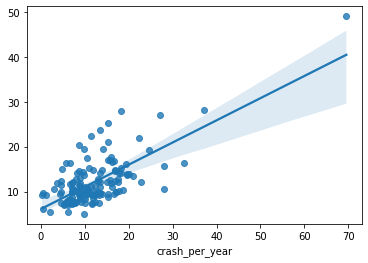

In [26]:
sns.regplot(y, pred)

### Plot residuals

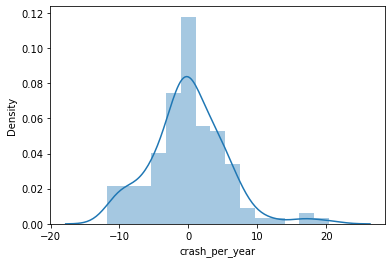

In [27]:
sns.distplot((y - pred), bins=15);

In [28]:
print('Mean crash per year: {:.1f}'.format(y.mean()))
print('Standard Dev crash per year: {:.1f}'.format(y.std()))

print()

print("Linear Regression Results:")
print('=========================')
print('Test set:')
print_evaluate(y, pred)


Mean crash per year: 12.0
Standard Dev crash per year: 7.6

Linear Regression Results:
Test set:
MAE: 3.98
MSE: 28.95
RMSE: 5.38
R2: 0.50


In [29]:
coefficients = dict(zip(X.columns,list(reg.coef_)))
for var in coefficients:
    print('{:>12}: {}'.format(var, coefficients[var]))

coefs_df = pd.DataFrame()
coefs_df['feature'] = list(X.columns)
coefs_df['coefficient'] = list(reg.coef_)


coefs_df.head(10)

 total_lanes: 0.9919558621287965
         way: 1.6232230437238457
       speed: 0.32002302448937886
        exit: 5.2445779558039645
       split: 10.690637829006642
   underpass: 0.976819319504212
    triangle: 0.9991731927151153
million_cars_per_year: 0.09867557626389543


,feature,coefficient
0,total_lanes,0.991956
1,way,1.623223
2,speed,0.320023
3,exit,5.244578
4,split,10.690638
5,underpass,0.976819
6,triangle,0.999173
7,million_cars_per_year,0.098676


In [30]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y, pred) , cross_val(reg, X, y)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "Cross Validation Score (r2)"])
results_df

,Model,MAE,MSE,RMSE,R2,Cross Validation Score (r2)
0,Linear Regression,3.975806,28.951023,5.380615,0.495812,0.094537


## Ridge Model

In [31]:
from sklearn.linear_model import Ridge, RidgeCV

model = Ridge()
model.fit(X, y)
pred = model.predict(X)


print("Ridge Regression Results:")
print('=========================')
print_evaluate(y, pred)


Ridge Regression Results:
MAE: 4.00
MSE: 29.07
RMSE: 5.39
R2: 0.49


In [32]:
ridge = pd.DataFrame(data=[["Ridge Regression", *evaluate(y, pred) , cross_val(model, X, y)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "Cross Validation Score (r2)"])
results_df.append(ridge)

,Model,MAE,MSE,RMSE,R2,Cross Validation Score (r2)
0,Linear Regression,3.975806,28.951023,5.380615,0.495812,0.094537
0,Ridge Regression,3.998220,29.067657,5.391443,0.493781,0.094621


## Random Forest Model

In [33]:
forest_cont = ['total_lanes', 'exit', 'split', 'way',
       'angled', 'triangle', 'one_way', 'turn_lanes',
        'million_cars_per_year', 'speed', 'underpass', 'medians']

forest_cat = ['region_id']

In [34]:
continuous

['crash_per_year',
 'avg_violations',
 'total_lanes',
 'medians',
 'way',
 'speed',
 'million_cars_per_year']

In [35]:
df_continuous = crash_df[forest_cont]  # ended up using same as linreg
#df_continuous.drop(columns=[target], inplace=True)

df_ohe = crash_df[forest_cat].astype(str)
df_ohe = pd.get_dummies(df_ohe, columns=forest_cat, drop_first=True)

df_final = pd.concat([df_continuous, df_ohe], axis=1)

In [36]:
from sklearn.model_selection import train_test_split

X = df_final
y = crash_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [37]:
from sklearn.ensemble import RandomForestRegressor
base = RandomForestRegressor(random_state = 42)
base.fit(X_train, y_train)

base.score(X_test, y_test)

-0.2893754020802852

In [38]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, 40],
    'max_features': [5, 10, 15, 20],
    'min_samples_leaf': [5],
    'min_samples_split': [2],
    'n_estimators': [200, 300, 1000]
}

# Create a based model
forest = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   56.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth':

In [39]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features=20, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [40]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features=10, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.10546887649903647

In [41]:
#y_pred = forest.predict(X_test)
y_pred = forest.predict(X)

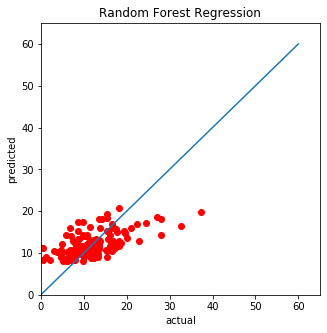

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# # Visualising the Random Forest Regression Results  
plt.figure(figsize=[5,5])
plt.scatter(y, y_pred, color='red')
plt.plot([0,60], [0, 60])
plt.title('Random Forest Regression')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.xlim(0,65)
plt.ylim(0,65)
plt.show()

### Obvious outlier is a very complex intersection (Stoney Island and 79th)
https://www.google.com/maps/place/S+South+Chicago+Ave,+Chicago,+IL+60649/@41.7517208,-87.5866419,18z/data=!3m1!4b1!4m5!3m4!1s0x880e288c47aa2dff:0x8bf4bcdffdf5f588!8m2!3d41.7517208!4d-87.5857653

In [43]:
print(forest.score(X_test, y_test)) # r2
df = pd.DataFrame(list(zip(X_test.columns, forest.feature_importances_)), columns=['feature', 'importance'])
df.sort_values(by='importance', ascending=False)[:10]


0.10546887649903647


,feature,importance
0,total_lanes,0.174438
8,million_cars_per_year,0.154131
9,speed,0.139006
11,medians,0.136847
2,split,0.095798
1,exit,0.088499
7,turn_lanes,0.065920
10,underpass,0.062923
5,triangle,0.018434
33,region_id_5,0.016889


In [44]:
# this intersection throws almost needs it's own category.  It's insane
crash_df[crash_df.n_crash==200]['intersection']

Series([], Name: intersection, dtype: object)

Average crashes per year (per intersection): 12.0
Max crashes per year: 69.5
Min crashes per year: 0.3
Std dev crashes per year: 7.6

Model on X_test set:
MAE: 3.36
MSE: 16.53
RMSE: 4.07
R2: 0.11

Model on X set:
MAE: 3.92
MSE: 36.67
RMSE: 6.06
R2: 0.36


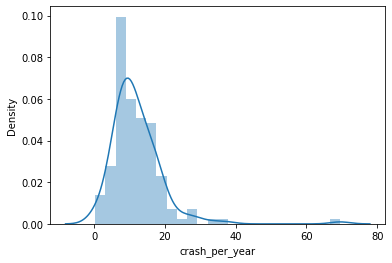

In [45]:
# Get mae to compare it
sns.distplot(y)
print('Average crashes per year (per intersection): {:.1f}'.format(y.mean()))
print('Max crashes per year: {:.1f}'.format(y.max()))
print('Min crashes per year: {:.1f}'.format(y.min()))
print('Std dev crashes per year: {:.1f}'.format(y.std()))


print()

print("Model on X_test set:")
pred = forest.predict(X_test)
print_evaluate(y_test, pred)

print()
pred= forest.predict(X)
print('Model on X set:')
print_evaluate(y, pred)



This is not a great result for the random forest.  It did not fare much better than the regressions.  I cold tune the hyperparameters, but will stick with Ridge regression for now.

## Results of intersection characteristic analysis
Linear Regression gave the better results.  I kept it because of the better cross validation and the ability to interpret the results.  The r2 value is not as meaningful since we trained and scored on the same set. 

The random forest explained approximately 38% of the test set, but appears to be overfitting to the training set.

Characteristics used : 'traffic', 'total_lanes', 'medians', 'speed', 'violations_per_year', 'n_cams'
Most important characteristics (by rank): 'total_lanes', 'cams'

These characteristics accounted for about half of the crashes by r-square value.  Adding in more characteristics improves performance, but the individual p_vals do not support their inclusion, and would risk overfitting on a small dataset.

From our linear regression coefficients:
Every 50 violations is one more accident per year. (this is the best predictor we have)
A 6 way intersection will have about 5 more accidents per year. (2.5 per way)
Each additional lane adds about one accident per year.
An intersection with 10mph higher speed limit has one more accident per year.


Only a handful of the gathered characteristics meaningfully informed the model.
One possible hypothesis: dangerous intersections have had characteristics changed to mitigate the accidents.  Medians, no turns, protected turns, no left, cameras etc. were installed to make the intersection safer.  Perhaps they only occur at the more dangerous intersections, and their presence is the result rather than the cause of the accidents and should not be considered.  For this reason, I chose to only keep variables that were inherent to the intersection, and could not be mitigated (lanes, ways, traffic, violations, split, triangles, overpasses, exits).


The random forest model produced a higher score (MSE) than the linear model.  It used similar features (violations, lanes, and traffic added the most predictive value to the model)